In [1]:
import pandas as pd
import numpy as np

accident_5 = pd.read_csv("accident_5_min_before.csv", encoding="cp949", index_col=0)
accident_10 = pd.read_csv("accident_10_min_before.csv", encoding="cp949", index_col=0)
accident_15 = pd.read_csv("accident_15_min_before.csv", encoding="cp949", index_col=0)
accident_20 = pd.read_csv("accident_20_min_before.csv", encoding="cp949", index_col=0)

non_accident_5 = pd.read_csv("non_accident_5_min_before.csv", encoding="cp949", index_col=0)
non_accident_10 = pd.read_csv("non_accident_10_min_before.csv", encoding="cp949", index_col=0)
non_accident_15 = pd.read_csv("non_accident_15_min_before.csv", encoding="cp949", index_col=0)
non_accident_20 = pd.read_csv("non_accident_20_min_before.csv", encoding="cp949", index_col=0)

In [2]:
dynamic_5 = accident_5[["rain", "temp", "humid", "visibility", "dew_point", "cloud", "vaper_press", "ground_temp", "sun_diff_angle", "sun_elevation", "speed", "lanes", "speed_limit", "length", "bump", "camera"]]
dynamic_10 = accident_10[["rain", "temp", "humid", "visibility", "dew_point", "cloud", "vaper_press", "ground_temp", "sun_diff_angle", "sun_elevation", "speed", "lanes", "speed_limit", "length", "bump", "camera"]]
dynamic_15 = accident_15[["rain", "temp", "humid", "visibility", "dew_point", "cloud", "vaper_press", "ground_temp", "sun_diff_angle", "sun_elevation", "speed", "lanes", "speed_limit", "length", "bump", "camera"]]
dynamic_20 = accident_20[["rain", "temp", "humid", "visibility", "dew_point", "cloud", "vaper_press", "ground_temp", "sun_diff_angle", "sun_elevation", "speed", "lanes", "speed_limit", "length", "bump", "camera"]]

non_dynamic_5 = non_accident_5[["rain", "temp", "humid", "visibility", "dew_point", "cloud", "vaper_press", "ground_temp", "sun_diff_angle", "sun_elevation", "speed", "lanes", "speed_limit", "length", "bump", "camera"]]
non_dynamic_10 = non_accident_10[["rain", "temp", "humid", "visibility", "dew_point", "cloud", "vaper_press", "ground_temp", "sun_diff_angle", "sun_elevation", "speed", "lanes", "speed_limit", "length", "bump", "camera"]]
non_dynamic_15 = non_accident_15[["rain", "temp", "humid", "visibility", "dew_point", "cloud", "vaper_press", "ground_temp", "sun_diff_angle", "sun_elevation", "speed", "lanes", "speed_limit", "length", "bump", "camera"]]
non_dynamic_20 = non_accident_20[["rain", "temp", "humid", "visibility", "dew_point", "cloud", "vaper_press", "ground_temp", "sun_diff_angle", "sun_elevation", "speed", "lanes", "speed_limit", "length", "bump", "camera"]]

In [3]:
def data_to_image(data):
    data_matrix = np.array(data).reshape(4, 4)
    return data_matrix

In [4]:
pos_data = []
for i in range(len(dynamic_5)):
    pos_5 = data_to_image(dynamic_5.iloc[i])
    pos_10 = data_to_image(dynamic_10.iloc[i])
    pos_15 = data_to_image(dynamic_15.iloc[i])
    pos_20 = data_to_image(dynamic_20.iloc[i])
    pos_data.append(np.concatenate((pos_20, pos_15, pos_10, pos_5), axis=1))

neg_data = []
for i in range(len(non_dynamic_5)):
    neg_5 = data_to_image(non_dynamic_5.iloc[i])
    neg_10 = data_to_image(non_dynamic_10.iloc[i])
    neg_15 = data_to_image(non_dynamic_15.iloc[i])
    neg_20 = data_to_image(non_dynamic_20.iloc[i])
    neg_data.append(np.concatenate((neg_20, neg_15, neg_10, neg_5), axis=1))

In [5]:
pos_data = np.array(pos_data)
pos_data = pos_data.reshape(-1, 4, 4, 4, 1)

In [6]:
neg_data = np.array(neg_data)
neg_data = neg_data.reshape(-1, 4, 4, 4, 1)
print(neg_data.shape)

(25062, 4, 4, 4, 1)


In [7]:
dataset = np.concatenate((pos_data, neg_data), axis=0)
label = np.concatenate((np.ones(len(pos_data)), np.zeros(len(neg_data))), axis=0)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size=0.2, random_state=1234, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1234, shuffle=True)

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input, BatchNormalization, ConvLSTM2D, Dense, Flatten
from tensorflow.keras.models import Model


In [10]:
input = Input(shape=(4, 4, 4, 1))

convlstm1 = ConvLSTM2D(filters=20, kernel_size=(3, 3), padding="same", return_sequences=True)(input)
bn1 = BatchNormalization()(convlstm1)

convlstm2 = ConvLSTM2D(filters=20, kernel_size=(3, 3), padding="same", return_sequences=False)(bn1)
bn2 = BatchNormalization()(convlstm2)

flatten = Flatten()(bn2)

dense1 = Dense(20, activation="relu")(flatten)
dense2 = Dense(1, activation="sigmoid")(dense1)

m = Model(inputs=input, outputs=dense2)

m.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.BinaryAccuracy(threshold=0.5)])

In [11]:
m.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 4, 4, 1)]      0         
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 4, 4, 4, 20)       15200     
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 4, 20)      80        
 ormalization)                                                   
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 4, 4, 20)          28880     
                                                                 
 batch_normalization_1 (Batc  (None, 4, 4, 20)         80        
 hNormalization)                                                 
                                                                 
 flatten (Flatten)           (None, 320)               0     

In [12]:
hist = m.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/50


2023-09-10 17:12:06.670027: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


627/627 [==============================] - 23s 34ms/step - loss: 0.6825 - accuracy: 0.5600 - auc: 0.5855 - precision: 0.5606 - recall: 0.5557 - binary_accuracy: 0.5600 - val_loss: 0.6820 - val_accuracy: 0.5656 - val_auc: 0.5929 - val_precision: 0.5613 - val_recall: 0.6230 - val_binary_accuracy: 0.5656
Epoch 2/50
627/627 [==============================] - 21s 34ms/step - loss: 0.6740 - accuracy: 0.5768 - auc: 0.6072 - precision: 0.5651 - recall: 0.6681 - binary_accuracy: 0.5768 - val_loss: 0.6740 - val_accuracy: 0.5842 - val_auc: 0.6166 - val_precision: 0.5731 - val_recall: 0.6782 - val_binary_accuracy: 0.5842
Epoch 3/50
627/627 [==============================] - 21s 34ms/step - loss: 0.6684 - accuracy: 0.5859 - auc: 0.6223 - precision: 0.5706 - recall: 0.6951 - binary_accuracy: 0.5859 - val_loss: 0.6700 - val_accuracy: 0.5900 - val_auc: 0.6269 - val_precision: 0.5759 - val_recall: 0.7004 - val_binary_accuracy: 0.5900
Epoch 4/50
627/627 [==============================] - 22s 35ms/step -

In [15]:
loss, acc, auc, precision, recall, binary_accuracy = m.evaluate(X_test, y_test, verbose=0)
print("m parameter", m.count_params())
print('loss : ', loss)
print('acc : ', acc)
print('auc : ', auc)
print('precision : ', precision)
print('recall : ', recall)
print('binary_accuracy : ', binary_accuracy)
#print f1-score with calculate recall precision

f1_score = (2 * precision * recall) / (precision + recall)
print('f1_score : ', f1_score)

m parameter 50681
loss :  0.7706377506256104
acc :  0.595451831817627
auc :  0.6220441460609436
precision :  0.5809759497642517
recall :  0.6609010696411133
binary_accuracy :  0.595451831817627
f1_score :  0.6183665864415574


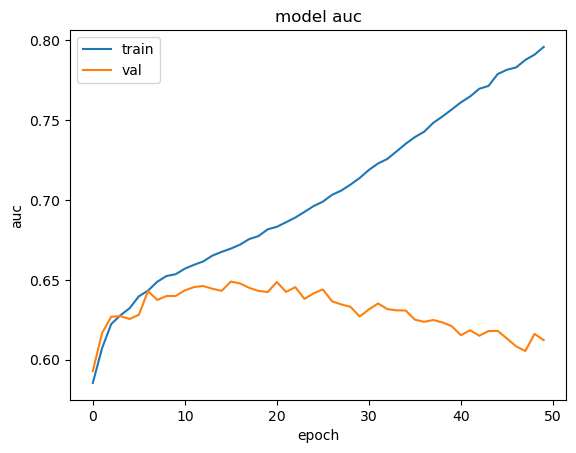

In [16]:
from matplotlib import pyplot as plt

plt.plot(hist.history['auc'])
plt.plot(hist.history['val_auc'])
plt.title('model auc')

plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()